In [56]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# adding '../ocean/src/model/' to sys.path
sys.path.append(os.path.abspath('../../ocean/src/model/'))

from model import SuperResolution

In [61]:
# Initialize some constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM_X = 272 # input image is going to be resized to this size
INPUT_DIM_Y = 160
DOWNGRADE_FACTOR = 16 # by how much the image resolution is going to be reduced (downgrade_factor = 10 ==> img.shape /= 10)
BATCH_SIZE = 1
PSI = 2

# loading the dataset
data_path = '../data/dataset/psi2/test_set' # setting path
# sequence of transformations to be done
transform = transforms.Compose([transforms.Resize((INPUT_DIM_X, INPUT_DIM_Y)),   # sequence of transformations to be done
                                transforms.Grayscale(num_output_channels=1), # on each image (resize, greyscale,
                                transforms.ToTensor()])                      # convert to tensor)

dataset = datasets.ImageFolder(root=data_path, transform=transform) # read data from folder

# if starting epoch is not 0, load from last trained model
model = SuperResolution().to(DEVICE)
model.load_state_dict(torch.load(f'../models/model_psi{PSI}_x{DOWNGRADE_FACTOR}_200'))

<All keys matched successfully>

In [62]:
def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

MSE between Low Resolution and High Resolution:  0.07452196822566735
MSE betweel Model Output and High Resolution:  0.07393304408479182
SSIM between Low Resolution and High Resolution:  0.3068484448222476
SSIM betweel Model Output and High Resolution:  0.2742201251028316


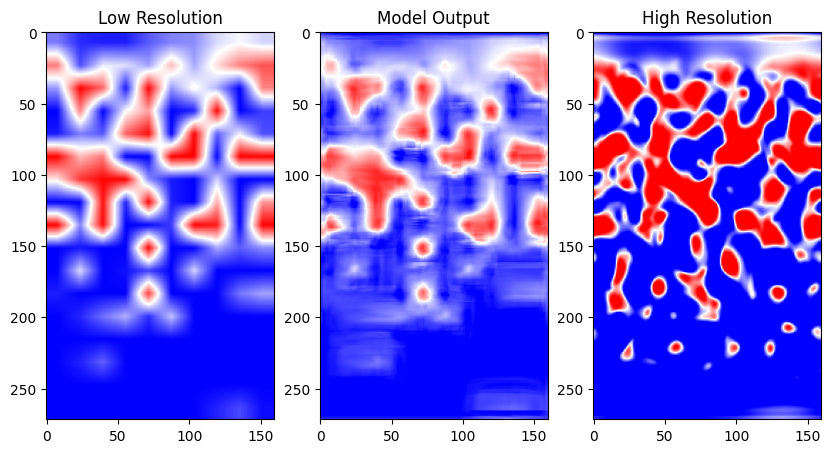

In [76]:
i = np.random.choice(len(dataset))
#print(i)
x = dataset[i][0]

lr_x = F.interpolate(x.unsqueeze(0), size=(INPUT_DIM_X//DOWNGRADE_FACTOR, INPUT_DIM_Y//DOWNGRADE_FACTOR), mode='bilinear', align_corners=False)
lr_x = F.interpolate(lr_x, size=(INPUT_DIM_X, INPUT_DIM_Y), mode='bilinear', align_corners=False)

y = model(lr_x[0].to(DEVICE)).cpu()[0].detach().numpy()

fig, axs = plt.subplots(1, 3, figsize=(10, 10))  # figsize ajustada para 3 imagens lado a lado
titles = ["Low Resolution", "Model Output", "High Resolution"]
images = [lr_x.cpu()[0][0], y, x.cpu()[0]]

for i in range(3):
    axs[i].imshow(images[i], cmap='bwr')
    axs[i].set_title(titles[i])
    #axs[i].axis('off')

print("MSE between Low Resolution and High Resolution: ", mse(lr_x.numpy()[0][0], x.numpy()[0]))
print("MSE betweel Model Output and High Resolution: ", mse(y, x.numpy()[0]))
print("SSIM between Low Resolution and High Resolution: ", ssim(lr_x.numpy()[0][0], x.numpy()[0], data_range=1))
print("SSIM betweel Model Output and High Resolution: ", ssim(y, x.numpy()[0], data_range=1))

plt.show()